In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import cv2
import math
from torchvision import transforms

In [2]:
directories = []

In [3]:
image_dict = {}

In [4]:
for _, dirs, _ in os.walk("train_images/"):
    directories = dirs
    break

In [5]:
for directory in directories:
    file_path = os.path.join("train_images", directory, "images")
    file_masks = os.path.join("train_images", directory, "masks")
    
    if directory.startswith("."):
        continue
    file_name = os.listdir(file_path)[0]
    full_path_image = os.path.join(file_path, file_name)
    
    image = full_path_image
    result_image = np.empty((360, 360, 3))

    for mask in os.listdir(file_masks):
        image_cv2 = cv2.imread(os.path.join(file_masks, mask))
        if image_cv2.shape[0] != 360:
            continue
        result_image += image_cv2
    
    if image not in image_dict:
        image_dict[image] = result_image
    else:
        continue

In [6]:
res = list(image_dict.keys())[0]

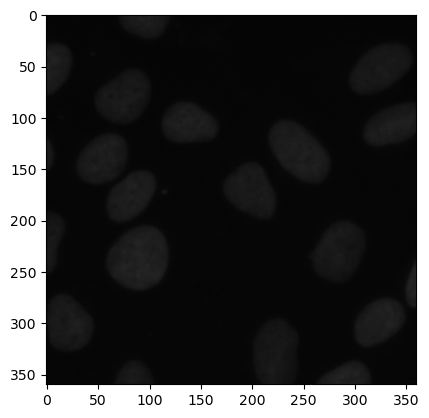

In [7]:
plt.imshow(cv2.imread(res))
plt.show()

In [8]:
np.max(image_dict[res])

255.0

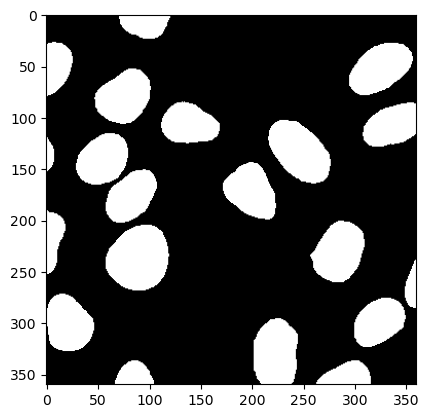

In [9]:
plt.imshow(image_dict[res] / 255)
plt.show()

In [10]:
(cv2.imread(res)).shape

(360, 360, 3)

In [11]:
img = torch.tensor(cv2.imread(res), dtype=torch.float)
img /= 255

In [12]:
img.std(), img.mean()

(tensor(0.0316), tensor(0.0420))

In [13]:
img_mask = torch.tensor(image_dict[res], dtype=torch.float)
img_mask /= 255

In [14]:
img_mask.std(), img.mean()

(tensor(0.4326), tensor(0.0420))

In [15]:
(1/2 * (img - img_mask) ** 2).mean()

tensor(0.1027)

In [16]:
loss = nn.MSELoss()

In [17]:
loss(img, img_mask)

tensor(0.2053)

In [18]:
def conv_block(inputs, in_channels, out_channels):
    layer = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels * 2, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2), stride=2)
    )
        
    return layer(inputs)

In [19]:
img.shape

torch.Size([360, 360, 3])

In [20]:
img = img.permute(2,0,1)

In [21]:
img.shape

torch.Size([3, 360, 360])

In [22]:
res = conv_block(img, img.shape[0], out_channels=img.shape[0] * 3)
res.shape

torch.Size([18, 180, 180])

In [23]:
res2 = conv_block(res, res.shape[0], out_channels=res.shape[0] * 3)

In [24]:
def upsample_block(inputs, in_channels, out_channels, prev_conv):
    first_up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2, padding=1)
    
    
    concatenated = prev_conv + first_up
    
    return concatenated

In [25]:
res.shape[0]

18

In [26]:
image = torch.randn((3,360,360))
conv = nn.ConvTranspose2d(image.shape[0], 32, kernel_size=3, stride=2)
print(conv(image).shape)

torch.Size([32, 721, 721])


In [27]:
conv_block(image, image.shape[0], 64).shape

torch.Size([128, 180, 180])

torch.Size([128, 16, 16])

torch.Size([128, 8, 8])

In [53]:
def conv_block(inputs, in_channels, out_channels):
    layer = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1),
        nn.ReLU(),
    )
    max_pool = nn.MaxPool2d(kernel_size=(2,2))
    output = max_pool(layer(inputs))
        
    return output

In [54]:
image = torch.randn((1,572,572))
res1 = conv_block(image, image.shape[0], 64)
res1.shape

torch.Size([64, 284, 284])

In [56]:
res2 = conv_block(res1, res1.shape[0], res1.shape[0] * 2)
res2.shape

torch.Size([128, 140, 140])

In [57]:
res3 = conv_block(res2, res2.shape[0], res2.shape[0] * 2)
res3.shape

torch.Size([256, 68, 68])

In [58]:
res4 = conv_block(res3, res3.shape[0], res3.shape[0] * 2)
res4.shape

torch.Size([512, 32, 32])

In [64]:
def bottle_neck(inputs, in_features, out_features):
    layer = nn.Sequential(
        nn.Conv2d(in_features, out_features, kernel_size=3, stride=1),
        nn.ReLU(),
        nn.Conv2d(out_features, out_features, kernel_size=3, stride=1),
        nn.ReLU()
    )
    return layer(inputs)

In [65]:
res5 = bottle_neck(res4, res4.shape[0], res4.shape[0] * 2)
res5.shape

torch.Size([1024, 28, 28])